INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


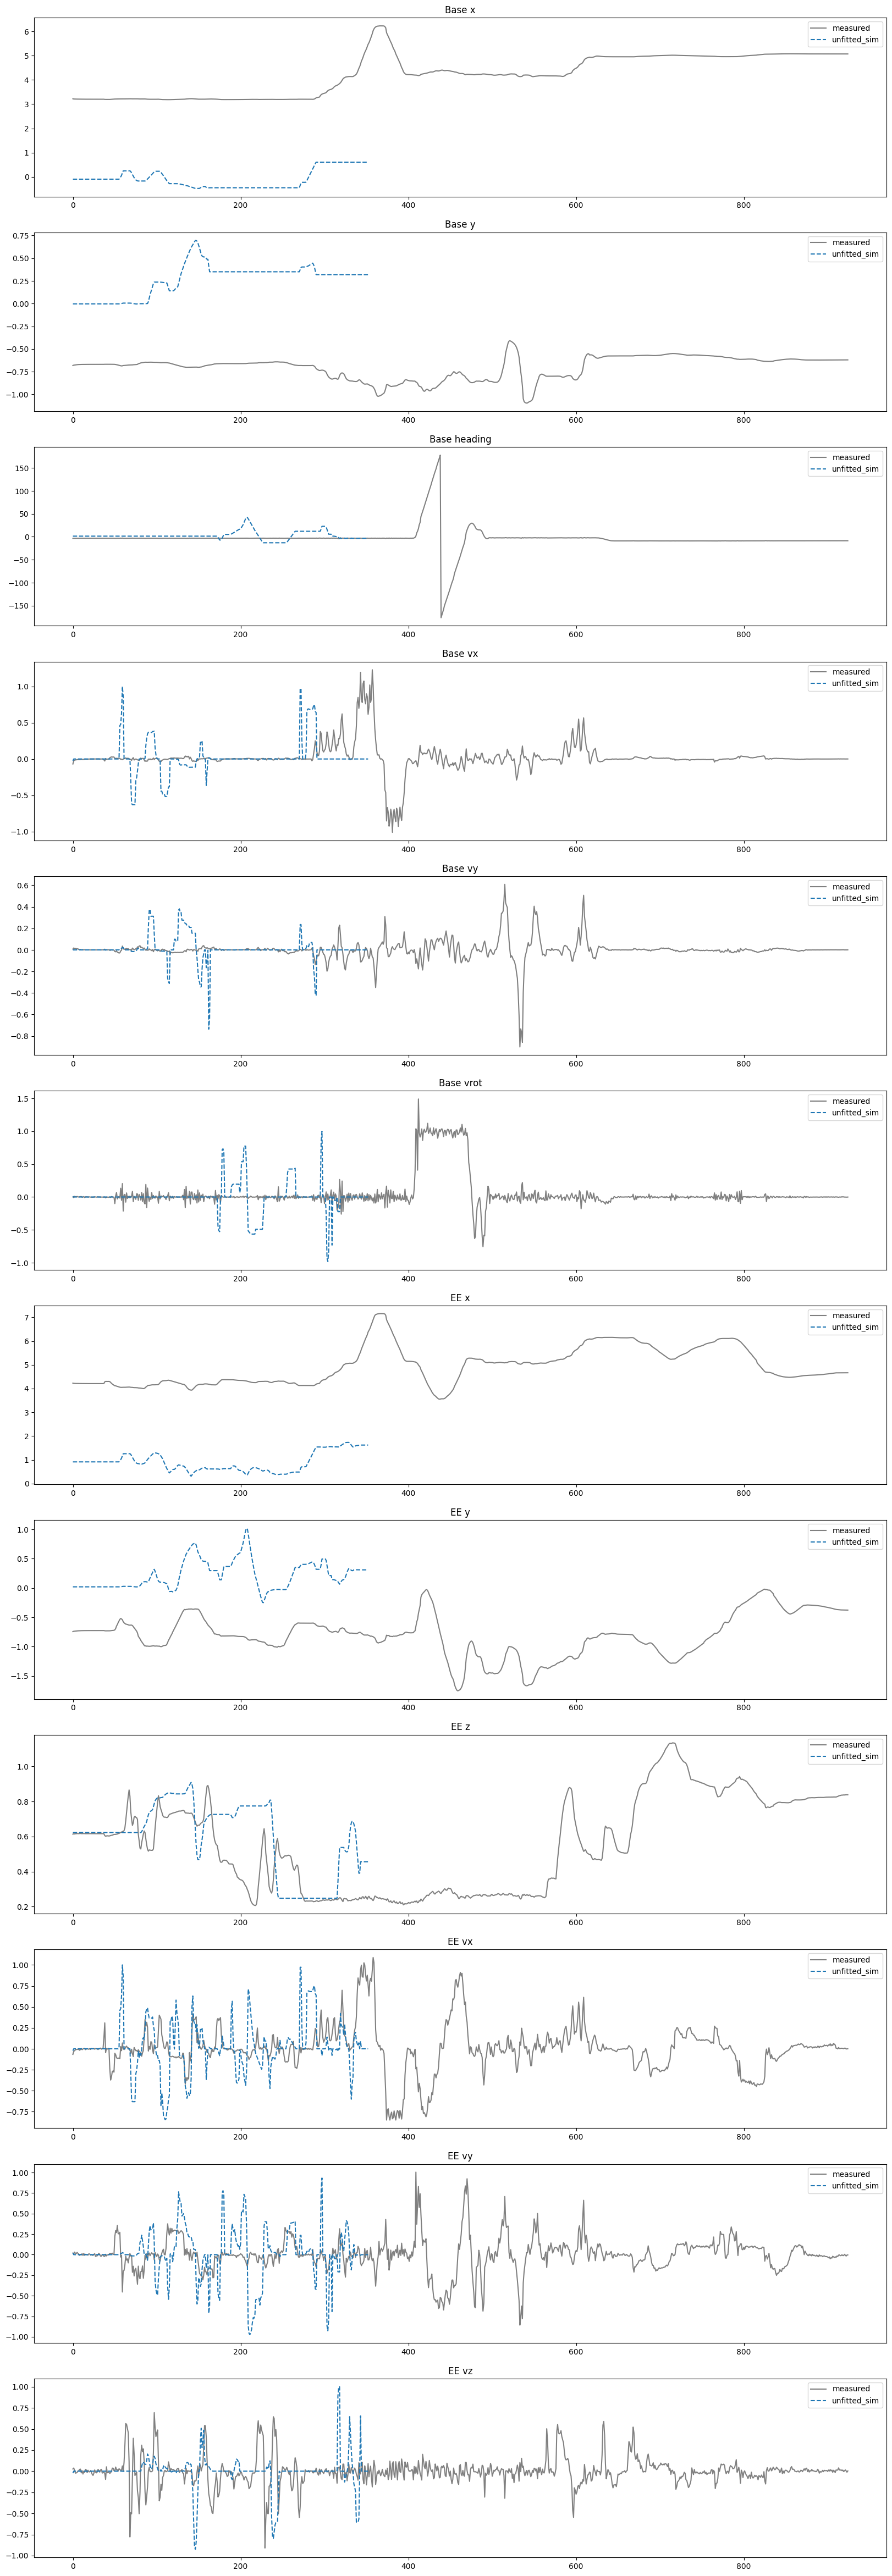

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

from alrd.run_spot import SessionBuffer, DataBuffer, TransitionData, StateData, TimeData
from alrd.spot_gym.model.robot_state import SpotState

# params
plot_actions = False

# load measured data
# measured_data_path = "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20240806-135621/session_buffer.pickle"
measured_data_path = "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20240815-151559/session_buffer.pickle"
with open(measured_data_path, "rb") as file:
    measured_data = pickle.load(file)

states = measured_data.data_buffers[0].states

# skip first step
states = states[1:]

measured_body_positions = np.array([s.next_state.pose_of_body_in_vision[0:3] for s in states])
measured_body_orientations = np.array([s.next_state.pose_of_body_in_vision[3:] for s in states])
measured_body_headings = R.from_quat(measured_body_orientations).as_euler('xyz', degrees=True)[:,2]
measured_body_velocities = np.array([s.next_state.velocity_of_body_in_vision for s in states])

measured_ee_positions = np.array([s.next_state.pose_of_hand_in_vision[0:3] for s in states])
measured_ee_orentations = np.array([s.next_state.pose_of_hand_in_vision[3:] for s in states])
# measured_ee_orentations = R.from_quat(measured_ee_orentations_pre).as_euler('xyz', degrees=True)
measured_ee_velocities = np.array([s.next_state.velocity_of_hand_in_vision for s in states])

measured_actions = np.array([s.action for s in states])


# load simlauted trajectory data
file_paths = {
    # "unfitted": "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/alrd/spot_simulator/generated_trajectories/trajectory_20240807-175628.pickle",
    # "fitted_tf": "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/alrd/spot_simulator/generated_trajectories/trajectory_tf_20240813-151404.pickle",
    # "fitted_scipy": "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/alrd/spot_simulator/generated_trajectories/trajectory_scipy_20240813-144211.pickle"
    "unfitted": "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/alrd/spot_simulator/generated_trajectories/trajectory_20240815-151559_20240816-113040.pickle"
}
data_sets = {}
for key, path in file_paths.items():
    with open(path, "rb" ) as file:
        data = pickle.load(file)

    base_x = [d[0] for d in data]
    base_y = [d[1] for d in data]
    heading = [d[2] for d in data]
    base_vx = [d[3] for d in data]
    base_vy = [d[4] for d in data]
    base_vrot = [d[5] for d in data]
    ee_x = [d[6] for d in data]
    ee_y = [d[7] for d in data]
    ee_z = [d[8] for d in data]
    ee_vx = [d[9] for d in data]
    ee_vy = [d[10] for d in data]
    ee_vz = [d[11] for d in data]

    data_sets[key] = {
        "base_x": base_x,
        "base_y": base_y,
        "heading": heading,
        "base_vx": base_vx,
        "base_vy": base_vy,
        "base_vrot": base_vrot,
        "ee_x": ee_x,
        "ee_y": ee_y,
        "ee_z": ee_z,
        "ee_vx": ee_vx,
        "ee_vy": ee_vy,
        "ee_vz": ee_vz
    }

# plot and label
fig, axs = plt.subplots(12, 1, figsize=(20, 60))

# base positions
axs[0].plot(measured_body_positions[:,0], label="measured", color="grey")
axs[1].plot(measured_body_positions[:,1], label="measured", color="grey")
axs[2].plot(measured_body_headings, label="measured", color="grey")
for key, data in data_sets.items():
    axs[0].plot(data["base_x"], label=key + "_sim", linestyle="--")
    axs[1].plot(data["base_y"], label=key + "_sim", linestyle="--")
    axs[2].plot(np.rad2deg(data["heading"]), label=key + "_sim", linestyle="--")

# base velocities
axs[3].plot(measured_body_velocities[:,0], label="measured", color="grey")
axs[4].plot(measured_body_velocities[:,1], label="measured", color="grey")
axs[5].plot(measured_body_velocities[:,5], label="measured", color="grey")
for key, data in data_sets.items():
    axs[3].plot(data["base_vx"], label=key + "_sim", linestyle="--")
    axs[4].plot(data["base_vy"], label=key + "_sim", linestyle="--")
    axs[5].plot(data["base_vrot"], label=key + "_sim", linestyle="--")


# end effector positions
axs[6].plot(measured_ee_positions[:,0], label="measured", color="grey")
axs[7].plot(measured_ee_positions[:,1], label="measured", color="grey")
axs[8].plot(measured_ee_positions[:,2], label="measured", color="grey")
for key, data in data_sets.items():
    axs[6].plot(data["ee_x"], label=key + "_sim", linestyle="--")
    axs[7].plot(data["ee_y"], label=key + "_sim", linestyle="--")
    axs[8].plot(data["ee_z"], label=key + "_sim", linestyle="--")

# end effector velocities
axs[9].plot(measured_ee_velocities[:,0], label="measured", color="grey")
axs[10].plot(measured_ee_velocities[:,1], label="measured", color="grey")
axs[11].plot(measured_ee_velocities[:,2], label="measured", color="grey")
for key, data in data_sets.items():
    axs[9].plot(data["ee_vx"], label=key + "_sim", linestyle="--")
    axs[10].plot(data["ee_vy"], label=key + "_sim", linestyle="--")
    axs[11].plot(data["ee_vz"], label=key + "_sim", linestyle="--")

if plot_actions:
    axs[3].plot(measured_actions[:,0], label="action", color="purple", linestyle="--")
    axs[4].plot(measured_actions[:,1], label="action", color="purple", linestyle="--")
    axs[5].plot(measured_actions[:,2], label="action", color="purple", linestyle="--")
    axs[9].plot(measured_actions[:,3], label="action", color="purple", linestyle="--")
    axs[10].plot(measured_actions[:,4], label="action", color="purple", linestyle="--")
    axs[11].plot(measured_actions[:,5], label="action", color="purple", linestyle="--")

for ax in axs:
    ax.legend()

# add labels
axs[0].set_title("Base x")
axs[1].set_title("Base y")
axs[2].set_title("Base heading")
axs[3].set_title("Base vx")
axs[4].set_title("Base vy")
axs[5].set_title("Base vrot")
axs[6].set_title("EE x")
axs[7].set_title("EE y")
axs[8].set_title("EE z")
axs[9].set_title("EE vx")
axs[10].set_title("EE vy")
axs[11].set_title("EE vz")


plt.show()
